In [1]:
import pandas as pd
import os
import numpy as np
import dask.dataframe as dd 
import warnings 
warnings.filterwarnings("ignore")



In [ ]:
import os
os.getcwd()

In [2]:
# Fichier avec les variables d'intéret :

df_cct = pd.read_parquet("cct_var_new.parquet")

FileNotFoundError: [Errno 2] No such file or directory: 'cct_var_new.parquet'

In [28]:
#df_cct = pd.read_csv("credit_card_transactions-ibm_v2.csv")
#df_cards = pd.read_csv("sd254_cards.csv")
#df_users = pd.read_csv("sd254_users.csv")
#df_cctu0 = pd.read_csv("User0_credit_card_transactions.csv")

In [29]:
#df_cct.to_parquet("df_cct.parquet")
#df_cards.to_parquet("df_cards.parquet")
#df_users.to_parquet("df_users.parquet")
#df_cctu0.to_parquet("df_users0.parquet")

In [11]:
# Transformation des données en parquet : 

df_cct = pd.read_parquet("df_cct.parquet")
df_cards = pd.read_parquet("df_cards.parquet")
df_users = pd.read_parquet("df_users.parquet")
df_cctu0 = pd.read_parquet("df_users0.parquet")

df_cct.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,None,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,None,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,None,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,None,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,None,No


In [12]:
# Un peu de nettoyage : 

# Supprimer les dollars :

df_cct["Amount"] = df_cct["Amount"].str.replace("$","")

In [13]:
# Convertir les "Amount" en float : 

df_users['Yearly Income - Person'] = df_users['Yearly Income - Person'].str.replace("$","")

df_cct["Amount"] = df_cct["Amount"].astype(float)

In [16]:
# Pour le moment on va travailler avec les 100 000 premières lignes. 
# Dans la suite, nous crérons un fichier parquet avec directement toutes les variables d'intérêt et feront DBSCAN sur 
# tout ce dataset. 


# Ajouter des nouvelles variables sur les 100 000 premières lignes : quelques variables d'intérêt pour faire un test 
# de DBSCAN

df_cct = df_cct.head(100000)


In [17]:
# Ajout : salaire journalier sur montant transaction (pour chaque transaction) 

df_users["Daily_income"] = df_users['Yearly Income - Person'].astype(np.float64)/360
df_cct["Amount/Dailyincome"] = np.nan
for i in range(len(df_cct["Merchant State"])):
    df_cct.loc[i,"Amount/Dailyincome"] = df_cct.iloc[i]["Amount"]/df_users.iloc[int(df_cct.iloc[i]["User"])]["Daily_income"]
df_cct.head()
    

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,Amount/Dailyincome
0,0,0,2002,9,1,06:21,134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,None,No,0.808637
1,0,0,2002,9,1,06:42,38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,None,No,0.232056
2,0,0,2002,9,2,06:22,120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,None,No,0.725717
3,0,0,2002,9,2,17:45,128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,None,No,0.777640
4,0,0,2002,9,3,06:23,104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,None,No,0.631459


In [18]:
# Localisation : binaire 0 ou 1 

df_cct["Comparison_trans"] = np.nan    
for i in range(len(df_cct["Merchant State"])):
    if df_cct.iloc[i]["Use Chip"] != 'Online Transaction' : 
        if df_cct.iloc[i]["Merchant State"] == df_users.iloc[np.int(df_cct.iloc[i]["User"])]["State"] : 
            df_cct.loc[i,"Comparison_trans"] = 0
        else :
            df_cct.loc[i,"Comparison_trans"] = 1
            
            
df_cct.head()




,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,Amount/Dailyincome,Comparison_trans
0,0,0,2002,9,1,06:21,134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,None,No,0.808637,0.0
1,0,0,2002,9,1,06:42,38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,None,No,0.232056,0.0
2,0,0,2002,9,2,06:22,120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,None,No,0.725717,0.0
3,0,0,2002,9,2,17:45,128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,None,No,0.777640,0.0
4,0,0,2002,9,3,06:23,104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,None,No,0.631459,0.0


In [21]:
df_cct1 = df_cct.copy()

In [27]:
df_cct = df_cct1
df_cct.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,Amount/Dailyincome,Comparison_trans
0,0,0,2002,9,1,06:21,134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,None,No,0.808637,0.0
1,0,0,2002,9,1,06:42,38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,None,No,0.232056,0.0
2,0,0,2002,9,2,06:22,120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,None,No,0.725717,0.0
3,0,0,2002,9,2,17:45,128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,None,No,0.777640,0.0
4,0,0,2002,9,3,06:23,104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,None,No,0.631459,0.0


In [28]:
def time(dataframe):
   dataframe[['Hours', 'Minutes']] = dataframe.Time.str.split(":", n=1, expand=True) #scinder la colonne Time en 2
   dataframe["Hours"] = dataframe["Hours"].astype(int)
   dataframe["Minutes"] = dataframe["Minutes"].astype(int)
   #Créer une colonne 'Timestamp' : format année, mois, jour, heure, minute:
   timestamp = pd.to_datetime(dataframe[["Year",'Month','Day','Hours','Minutes']], format = '%Y:%M:%D%:%H:%M')
   date = pd.to_datetime(dataframe[["Year",'Month','Day']], format = '%Y:%M:%D%')
   dataframe["date"] = date.values
   dataframe["timestamp"] = timestamp.values
   dataframe["delta_t_card"] = (timestamp-timestamp.shift()) #calculer l'intervalle de temps entre
   #deux transactions de la même carte et du même user

   #Convertir delta_t_card en secondes et mettre à 0 les temps négatifs 
   #(ici, dataframe ordonné en fonction de l'user et de la carte, et non de la chronologie):
   dataframe["delta_t_s_card"] = dataframe["delta_t_card"].dt.total_seconds().fillna(0).astype(int)
   dataframe["delta_t_s_card"] = dataframe["delta_t_s_card"].mask(dataframe["delta_t_s_card"] < 0, 0)

   #Réordonner les transactions en fonction du User et de la chronoogie de ses transactions : 
   dataframe = dataframe.sort_values(["User", "Year","Month","Day","Hours","Minutes"], ascending=[True,True,True,True,True,True]).reset_index(drop=True)
   timestamp2 = pd.to_datetime(dataframe[["Year",'Month','Day','Hours','Minutes']], format = '%Y:%M:%D%:%H:%M')
   dataframe['delta_t'] = (timestamp2-timestamp2.shift()) #différence de temps entre deux transactions du même user
   dataframe["delta_t_s"] = dataframe["delta_t"].dt.total_seconds().fillna(0).astype(int) #pour la première
   #transaction, fixer le delta_t_s à 0
   dataframe = dataframe[['User', 'Card', 'date', 'timestamp', 'Amount', 'Use Chip',
       'Merchant Name', 'Merchant City', 'Merchant State', 'Zip', 'MCC',
       'Errors?', 'Is Fraud?', 'delta_t_s','delta_t_s_card', 'Amount/Dailyincome', 'Comparison_trans', 'Time', 'Day']] #ordonner et sélectionner les colonnes
   
   return dataframe




In [29]:
df_cct = time(df_cct)

In [30]:
df_cct.head()

,User,Card,date,timestamp,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,delta_t_s,delta_t_s_card,Amount/Dailyincome,Comparison_trans,Time,Day
0,0,0,2002-09-01,2002-09-01 06:21:00,134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,None,No,0,0,0.808637,0.0,06:21,1
1,0,0,2002-09-01,2002-09-01 06:42:00,38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,None,No,1260,1260,0.232056,0.0,06:42,1
2,0,0,2002-09-02,2002-09-02 06:22:00,120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,None,No,85200,85200,0.725717,0.0,06:22,2
3,0,0,2002-09-02,2002-09-02 17:45:00,128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,None,No,40980,40980,0.777640,0.0,17:45,2
4,0,0,2002-09-03,2002-09-03 06:23:00,104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,None,No,45480,45480,0.631459,0.0,06:23,3


In [31]:
# Variables journalière : 


#Determining the daily amount of transactions


day_amt_v = df_cct.groupby(["User", "date"])["Amount"].sum().values
day_amt_i = df_cct.groupby(["User", "date"])["Amount"].sum().index
#Determining the daily number of transactions


day_nbt_v = df_cct.groupby(["User", "date"])["Amount"].size().values
day_nbt_i = df_cct.groupby(["User", "date"])["Amount"].size().index

df1 = pd.DataFrame(day_amt_v,day_amt_i,columns=["day_amt"]).reset_index()
df2 = pd.DataFrame(day_nbt_v,day_nbt_i,columns=["day_nbt"]).reset_index()


df1["day_nbt"] = df2["day_nbt"]
df1["day_med_nbt"] = df1["day_nbt"].expanding().median()

In [32]:
df_cct = df_cct.merge(df1,on=["User","date"])

In [33]:
df_cct.head()

,User,Card,date,timestamp,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,...,Is Fraud?,delta_t_s,delta_t_s_card,Amount/Dailyincome,Comparison_trans,Time,Day,day_amt,day_nbt,day_med_nbt
0,0,0,2002-09-01,2002-09-01 06:21:00,134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,...,No,0,0,0.808637,0.0,06:21,1,172.57,2,2.0
1,0,0,2002-09-01,2002-09-01 06:42:00,38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,...,No,1260,1260,0.232056,0.0,06:42,1,172.57,2,2.0
2,0,0,2002-09-02,2002-09-02 06:22:00,120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,...,No,85200,85200,0.725717,0.0,06:22,2,249.29,2,2.0
3,0,0,2002-09-02,2002-09-02 17:45:00,128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,...,No,40980,40980,0.777640,0.0,17:45,2,249.29,2,2.0
4,0,0,2002-09-03,2002-09-03 06:23:00,104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,...,No,45480,45480,0.631459,0.0,06:23,3,190.90,2,2.0


In [34]:
# Variables hebdomadaires : 

df = pd.DataFrame()
#Création des variables:
#wk_i_nbt: nombre de transactions hebdomadaires (jour 1: première transaction de chaque user)
#wk_med_nbt: nombre médian de transactions hebdomadaires (jusqu'à la semaine i)
#wk_i_amt: nmontant total des transactions hebdomadaires 
#wk_med_amt: montant médian des transactions hebdomadaires (jusqu'à la semaine i)

for i in range(len(df_cct["User"].unique())):
    df3 = pd.DataFrame(df_cct[df_cct["User"] == i][['User',"date"]])
    wk_nbt_i = df_cct[df_cct["User"] == i].groupby([pd.Grouper(key="date", freq="7d")]).size().index
    wk_nbt_v = df_cct[df_cct["User"] == i].groupby([pd.Grouper(key="date", freq="7d")]).size().values


    wk_amt_i = df_cct[df_cct["User"] == i].groupby([pd.Grouper(key="date", freq="7d")])["Amount"].sum().index
    wk_amt_v = df_cct[df_cct["User"] == i].groupby([pd.Grouper(key="date", freq="7d")])["Amount"].sum().values

    wk_amt_med_i = df_cct[df_cct["User"] == i].groupby([pd.Grouper(key="date", freq="7d")])["Amount"].median().index
    wk_amt_med_v = df_cct[df_cct["User"] == i].groupby([pd.Grouper(key="date", freq="7d")])["Amount"].median().values

    df4 = pd.DataFrame(wk_nbt_v,wk_nbt_i, columns=["wk_i_nbt"]).reset_index()
    df4["User"] = i
    df4["wk_med_nbt"] = df4["wk_i_nbt"].expanding().median()
    df4["wk_i_amt"] = wk_amt_v
    df4["wk_med_amt"] = df4["wk_i_amt"].expanding().median()
    df4["wk_i_med_amt"] = wk_amt_med_v
 
    df5 = pd.merge(df3,df4,how='left',on=["User","date"])
    df = pd.concat([df,df5], axis=0)
    df = df[['wk_i_nbt', 'wk_med_nbt', 'wk_i_amt',
       'wk_med_amt','wk_i_med_amt']].fillna(method="ffill")
    

df.reset_index(drop=True, inplace=True) #dataframe avec les 4 nouvelles var. hebdomdaires

In [35]:
df["nbt_wk_i/amt_wk_i"] = df["wk_i_nbt"]/df["wk_i_med_amt"]

In [36]:
df_cct = pd.concat([df_cct,df[['wk_i_nbt', 'wk_med_nbt', 'wk_i_amt',
       'wk_med_amt',"wk_i_med_amt","nbt_wk_i/amt_wk_i"]]], axis=1)

In [37]:
df_cct.head()

,User,Card,date,timestamp,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,...,Day,day_amt,day_nbt,day_med_nbt,wk_i_nbt,wk_med_nbt,wk_i_amt,wk_med_amt,wk_i_med_amt,nbt_wk_i/amt_wk_i
0,0,0,2002-09-01,2002-09-01 06:21:00,134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,...,1,172.57,2,2.0,16.0,16.0,1380.96,1380.96,90.015,0.177748
1,0,0,2002-09-01,2002-09-01 06:42:00,38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,...,1,172.57,2,2.0,16.0,16.0,1380.96,1380.96,90.015,0.177748
2,0,0,2002-09-02,2002-09-02 06:22:00,120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,...,2,249.29,2,2.0,16.0,16.0,1380.96,1380.96,90.015,0.177748
3,0,0,2002-09-02,2002-09-02 17:45:00,128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,...,2,249.29,2,2.0,16.0,16.0,1380.96,1380.96,90.015,0.177748
4,0,0,2002-09-03,2002-09-03 06:23:00,104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,...,3,190.90,2,2.0,16.0,16.0,1380.96,1380.96,90.015,0.177748


In [41]:
df_cct.columns

Index(['User', 'Card', 'date', 'timestamp', 'Amount', 'Use Chip',
       'Merchant Name', 'Merchant City', 'Merchant State', 'Zip', 'MCC',
       'Errors?', 'Is Fraud?', 'delta_t_s', 'delta_t_s_card',
       'Amount/Dailyincome', 'Comparison_trans', 'Time', 'Day', 'day_amt',
       'day_nbt', 'day_med_nbt', 'wk_i_nbt', 'wk_med_nbt', 'wk_i_amt',
       'wk_med_amt', 'wk_i_med_amt', 'nbt_wk_i/amt_wk_i'],
      dtype='object')

In [38]:
# DBSCAN 

# 1 importation des packages : 

import pandas.util.testing as tm
import seaborn as sns
from sklearn import cluster 
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import umap
from collections import Counter

In [39]:
df_cct2 = df_cct.copy()

In [43]:
df_cct = df_cct2

In [44]:
# Etape 1 : transformer toutes les données en float, supprimer les nan, centrer réduire le tout : 


df_cct["Time"] = df_cct["Time"].str.replace(":","")
df_cct["Time"] = pd.to_numeric(df_cct["Time"])





In [45]:
# Transformer Merchant City en float : 


for i,e in enumerate(df_cct["Merchant City"].unique()):
    df_cct['Merchant City'][df_cct['Merchant City'] == e] = i
df_cct['Merchant City'] = df_cct['Merchant City'].fillna(0)



In [46]:
# Transformer Use Chip en code float : 


pd.options.mode.chained_assignment = None
df_cct['Use Chip'][df_cct['Use Chip'] == 'Swipe Transaction'] = 0
df_cct['Use Chip'][df_cct['Use Chip'] == 'Online Transaction'] = 1
df_cct['Use Chip'][df_cct['Use Chip'] == 'Chip Transaction'] = 2

df_cct.head()

,User,Card,date,timestamp,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,...,Day,day_amt,day_nbt,day_med_nbt,wk_i_nbt,wk_med_nbt,wk_i_amt,wk_med_amt,wk_i_med_amt,nbt_wk_i/amt_wk_i
0,0,0,2002-09-01,2002-09-01 06:21:00,134.09,0,3527213246127876953,0,CA,91750.0,...,1,172.57,2,2.0,16.0,16.0,1380.96,1380.96,90.015,0.177748
1,0,0,2002-09-01,2002-09-01 06:42:00,38.48,0,-727612092139916043,1,CA,91754.0,...,1,172.57,2,2.0,16.0,16.0,1380.96,1380.96,90.015,0.177748
2,0,0,2002-09-02,2002-09-02 06:22:00,120.34,0,-727612092139916043,1,CA,91754.0,...,2,249.29,2,2.0,16.0,16.0,1380.96,1380.96,90.015,0.177748
3,0,0,2002-09-02,2002-09-02 17:45:00,128.95,0,3414527459579106770,1,CA,91754.0,...,2,249.29,2,2.0,16.0,16.0,1380.96,1380.96,90.015,0.177748
4,0,0,2002-09-03,2002-09-03 06:23:00,104.71,0,5817218446178736267,0,CA,91750.0,...,3,190.90,2,2.0,16.0,16.0,1380.96,1380.96,90.015,0.177748


In [50]:
# Transformer Errors? en float.

# Transformer Merchant State en float. 

for i,e in enumerate(df_cct["Merchant State"].unique()):
    df_cct['Merchant State'][df_cct['Merchant State'] == e] = i
df_cct['Merchant State'] = df_cct['Merchant State'].fillna(0)


for i,e in enumerate(df_cct["Errors?"].unique()):
    df_cct['Errors?'][df_cct['Errors?'] == e] = i
df_cct['Errors?'] = df_cct['Errors?'].fillna(0)
df_cct.head()


,User,Card,date,timestamp,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,...,Day,day_amt,day_nbt,day_med_nbt,wk_i_nbt,wk_med_nbt,wk_i_amt,wk_med_amt,wk_i_med_amt,nbt_wk_i/amt_wk_i
0,0,0,2002-09-01,2002-09-01 06:21:00,134.09,0,3527213246127876953,0,0,91750.0,...,1,172.57,2,2.0,16.0,16.0,1380.96,1380.96,90.015,0.177748
1,0,0,2002-09-01,2002-09-01 06:42:00,38.48,0,-727612092139916043,1,0,91754.0,...,1,172.57,2,2.0,16.0,16.0,1380.96,1380.96,90.015,0.177748
2,0,0,2002-09-02,2002-09-02 06:22:00,120.34,0,-727612092139916043,1,0,91754.0,...,2,249.29,2,2.0,16.0,16.0,1380.96,1380.96,90.015,0.177748
3,0,0,2002-09-02,2002-09-02 17:45:00,128.95,0,3414527459579106770,1,0,91754.0,...,2,249.29,2,2.0,16.0,16.0,1380.96,1380.96,90.015,0.177748
4,0,0,2002-09-03,2002-09-03 06:23:00,104.71,0,5817218446178736267,0,0,91750.0,...,3,190.90,2,2.0,16.0,16.0,1380.96,1380.96,90.015,0.177748


In [52]:
# On supprime date et timestamp pour le moment : on garde uniquement l'info de Day et Time. Sinon repétitif. 

df_cct = df_cct.drop(["timestamp", "date"], axis = 1)



In [54]:
df_cct.head()

array(['No', 'Yes'], dtype=object)

In [55]:
# Transformer les Is Fraud? en float : 

df_cct['Is Fraud?'][df_cct['Is Fraud?'] == 'No'] = 0
df_cct['Is Fraud?'][df_cct['Is Fraud?'] == 'Yes'] = 1


# Supprimer les lignes avec encore des NA. 

df_cct = df_cct.dropna() 



# Le jeu de donnée ne contient plus que des numerics.  

# Centrer réduire toutes les variables : (on utilise la distance euclidienne pour DBSCAN, on a besoin 
# de variables centrées réduites pour que ça fasse sens.)

for i in range(len(df_cct.columns)):
    mean = np.mean(df_cct[df_cct.columns[i]])
    ec = np.std(df_cct[df_cct.columns[i]])
    df_cct[df_cct.columns[i]] = (df_cct[df_cct.columns[i]]-mean)/ec


df_cct.head()



,User,Card,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,...,Day,day_amt,day_nbt,day_med_nbt,wk_i_nbt,wk_med_nbt,wk_i_amt,wk_med_amt,wk_i_med_amt,nbt_wk_i/amt_wk_i
0,-1.363499,-1.036766,0.476883,-0.548262,0.774386,-0.703651,-0.491613,0.541862,-0.380008,-0.117263,...,-1.672245,-0.438666,-1.041638,-2.964574,-0.812231,-0.705068,-0.420274,-0.042111,1.148625,-0.767687
1,-1.363499,-1.036766,-0.235072,-0.548262,-0.123023,-0.699073,-0.491613,0.541982,-0.244768,-0.117263,...,-1.672245,-0.438666,-1.041638,-2.964574,-0.812231,-0.705068,-0.420274,-0.042111,1.148625,-0.767687
2,-1.363499,-1.036766,0.374494,-0.548262,-0.123023,-0.699073,-0.491613,0.541982,-0.244768,-0.117263,...,-1.558599,-0.162034,-1.041638,-2.964574,-0.812231,-0.705068,-0.420274,-0.042111,1.148625,-0.767687
3,-1.363499,-1.036766,0.438608,-0.548262,0.750618,-0.699073,-0.491613,0.541982,0.047643,-0.117263,...,-1.558599,-0.162034,-1.041638,-2.964574,-0.812231,-0.705068,-0.420274,-0.042111,1.148625,-0.767687
4,-1.363499,-1.036766,0.258106,-0.548262,1.257383,-0.703651,-0.491613,0.541862,0.365640,-0.117263,...,-1.444954,-0.372573,-1.041638,-2.964574,-0.812231,-0.705068,-0.420274,-0.042111,1.148625,-0.767687


In [56]:
len(df_cct)

# On travaille donc sur 76 506 lignes. 

76506

In [57]:
# Implémentation de DBSCAN



X = df_cct.values
X.astype(np.float64)


array([[-1.36349947, -1.03676602,  0.47688309, ..., -0.0421113 ,
         1.14862505, -0.76768736],
       [-1.36349947, -1.03676602, -0.23507199, ..., -0.0421113 ,
         1.14862505, -0.76768736],
       [-1.36349947, -1.03676602,  0.37449441, ..., -0.0421113 ,
         1.14862505, -0.76768736],
       ...,
       [ 2.11603977, -1.03676602,  0.1697915 , ..., -0.40439648,
        -0.66081191, -0.19253824],
       [ 2.11603977, -1.03676602, -0.10446126, ..., -0.41690575,
        -0.08945148, -0.98609131],
       [ 2.11603977, -1.03676602, -0.07482438, ..., -0.41690575,
        -0.08945148, -0.98609131]])

In [61]:
# Maintenant : Choisir eps et min_samples : 

clustering=cluster.DBSCAN(eps=0.30, min_samples=2)
clustering.fit(X)s

DBSCAN(eps=0.3, min_samples=2)

In [62]:
np.unique(clustering.labels_)

array([  -1,    0,    1, ..., 1799, 1800, 1801], dtype=int64)

In [60]:
labels = clustering.labels_
d = Counter(labels)
d[-1]

76506

In [70]:
Eps=np.linspace(1,2.5,num=10)
N=[]
L=[]
for eps in Eps:
  clustering =  cluster.DBSCAN(eps=eps, min_samples=5)
  clustering.fit(X)
  labels = clustering.labels_
  L.append(labels)
  n=np.unique(labels)
  N+=[len(n)]

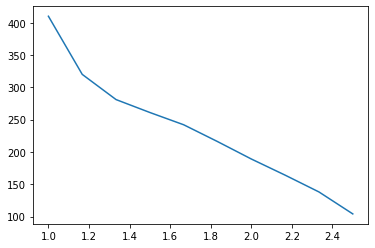

In [71]:
sns.lineplot(x=Eps,y=N)

In [74]:
# Regarder le nombre d'outliers : 


#clustering=cluster.DBSCAN(eps=1.3, min_samples=5)
#clustering.fit(X)
#labels = clustering.labels_


for s in L:
    d = Counter(s)
    for i in d:
        print(i, d[i])

0 12
-1 32027
1 9644
2 10
3 5
25 5
4 7
5 5
9 113
6 68
7 207
8 6
10 6
11 79
13 90
12 149
19 11
16 10
14 8
15 5
34 7
33 7
58 5
37 6
18 6
32 4
17 6
22 5
36 5
35 4
28 5
20 17
21 5
24 3
23 2
38 5
51 3
26 5
27 5
29 6
30 2
31 5
39 87
40 691
41 94
42 11
43 42
44 18
45 12
46 6
55 11
47 12
48 5
57 9
49 7
61 5
50 9
52 10
59 4
65 10
53 13
66 5
54 2
64 5
62 4
63 6
56 2
60 4
67 1055
68 720
69 115
70 104
71 48
72 97
73 51
92 10
74 52
75 6
88 5
77 5
76 7
78 7
82 11
79 8
80 9
81 7
83 8
91 7
85 4
86 6
87 3
93 5
84 5
89 3
90 4
94 5
95 5
96 8
102 5
97 7
100 5
101 5
98 6
103 7
99 5
104 16
105 140
106 20
122 16
111 50
120 74
133 5
107 25
123 10
108 7
109 11
110 46
114 32
118 22
113 7
112 5
121 12
115 6
117 13
135 5
124 20
116 4
119 6
126 14
129 7
134 5
132 5
131 5
125 5
127 5
128 8
130 9
141 50
136 676
137 14
138 1040
140 266
139 453
150 24
142 141
157 7
143 19
144 119
158 5
145 8
146 5
159 9
149 13
160 5
147 5
148 20
151 5
152 5
153 5
154 6
155 7
156 6
161 6303
162 303
163 76
168 16
165 1630
164 342
166 14

127 8
128 6
129 5
130 4
135 4
131 26
132 5
133 4
134 8
136 5
137 5
138 5
139 5
140 2347
148 4
142 17
141 7
143 8
145 3
144 24
147 7
146 6
149 8
164 12
166 8
158 15
150 10
151 7
152 10
153 5
154 4
155 5
156 6
157 5
159 5
160 13
161 5
162 5
167 11
163 7
165 6
168 10746
172 37
179 5
169 154
171 7
183 20
170 26
191 8
185 8
173 11
174 13
180 5
175 25
176 8
194 6
177 12
178 6
193 5
186 27
181 35
182 5
190 8
184 6
187 10
188 13
189 8
195 5
192 5
196 6
197 2965
198 19
199 157
200 161
201 7
208 6
202 7
211 4
203 11
204 6
205 5
206 5
207 4
209 6
210 5
212 146
213 237
214 14
0 13770
-1 6965
1 324
2 7
3 5
4 5
5 5
6 525
17 6
7 8
18 5
16 5
8 7
13 8
9 15
10 11
11 6
12 17
14 6
15 5
23 5
19 5
20 2428
21 12
22 39
24 8
25 15
26 5
27 18
28 6
29 7691
36 8
30 87
42 6
31 20
32 28
33 28
40 5
39 5
34 4
35 5
37 5
38 5
41 5
43 2013
44 35
45 7
47 5
46 9
48 5
49 17855
50 47
51 116
52 6
56 5
53 6
54 29
55 8
57 11
58 11
59 10
60 684
62 8
61 19
79 52
67 16
63 6
64 7
65 9
66 6
68 6
69 6
70 5
71 5
72 9
73 13
74 5
75 5


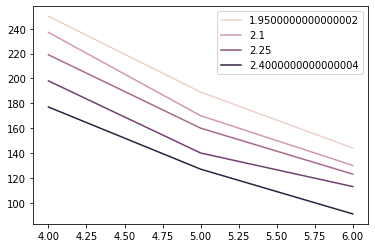

In [75]:
Sample=range(4,7)
Eps = [2.0,2.1,2.2,2.3,2.4]
N=[]

x = []
hue = []

for sample in Sample:
  for eps in Eps:
    clustering=cluster.DBSCAN(eps, min_samples=sample)
    clustering.fit(X)
    labels=clustering.labels_
    n=np.unique(labels)
    N+=[len(n)]

    x.append(eps) 
    hue.append(sample)

sns.lineplot(x= hue,y=N, hue = x)

In [76]:
# Visualisation : réduction de dimension... 

# 1. ACP

# 2. UMAP

# 1. # On choisit de faire DBSCAN avec eps = 2.25 et min_samples = 5 


clustering=cluster.DBSCAN(eps=2.25, min_samples=5)
clustering.fit(X)
np.unique(clustering.labels_)

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151], dtype=int64)

In [77]:
labels = clustering.labels_
d = Counter(labels)
d[-1]

# 5184 outliers

5184

In [78]:
# ACP


pca = PCA()
pca.fit(df_cct)

PCA()

In [79]:
df_cct_pca = pca.transform(df_cct)
df_cct_pca_df = pd.DataFrame({
    "Dim1" : df_cct_pca[:,0], 
    "Dim2" : df_cct_pca[:,1]})
df_cct_pca_df["labels"] = clustering.labels_
df_cct_pca_df["Merchant State"] = df_cct["Merchant State"]
df_cct_pca_df["Amount"] = df_cct["Amount"]



'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


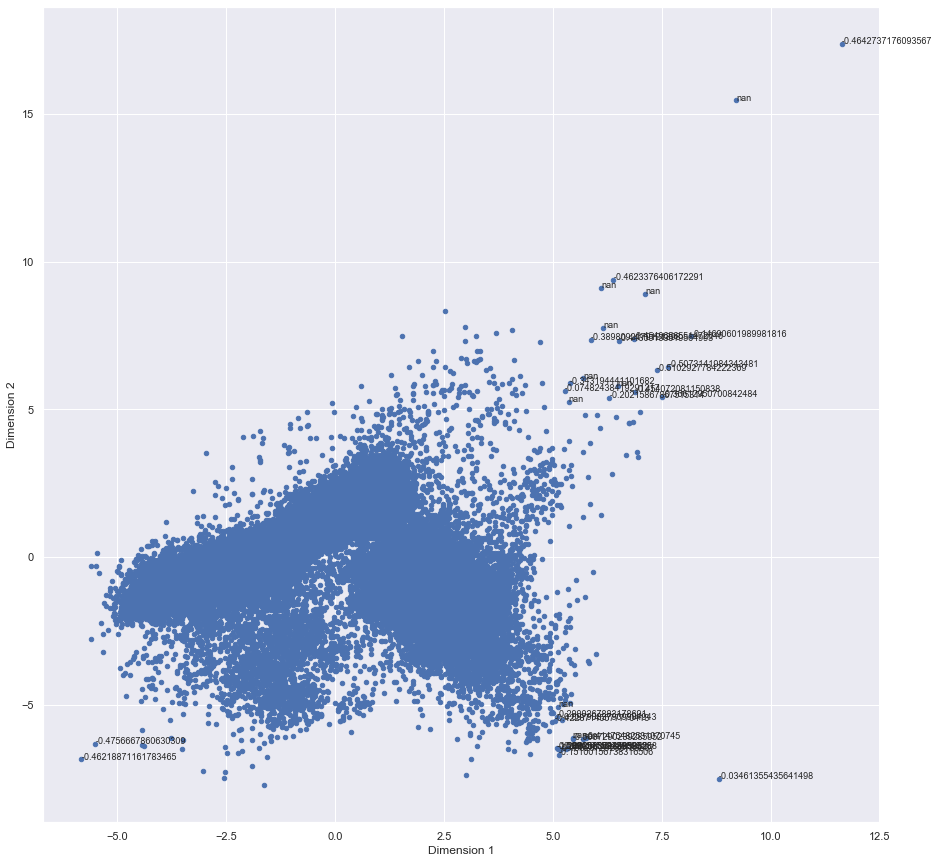

In [85]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 15))
df_cct_pca_df.plot.scatter("Dim1", "Dim2", ax = ax)

# boucle sur chaque pays
for k in df_cct_pca_df.iterrows():
    # annotation uniquement si valeur absolue sur une de 2 dimensions importantes (valeurs choisies empiriquement)
    if (abs(k[1]['Dim1']) > 5) & (abs(k[1]['Dim2']) > 5):
        ax.annotate(k[1]["Amount"], (k[1]['Dim1'], k[1]['Dim2']), fontsize = 9)
plt.xlabel("Dimension 1") 
plt.ylabel("Dimension 2")
plt.show()


# But : essayer de comprendre les axes pour pouvoir interpréter les groupes. 
# Regarder un peu à quoi correspond les points extrêmes en terme de type de variables pour interpréter les axes. 

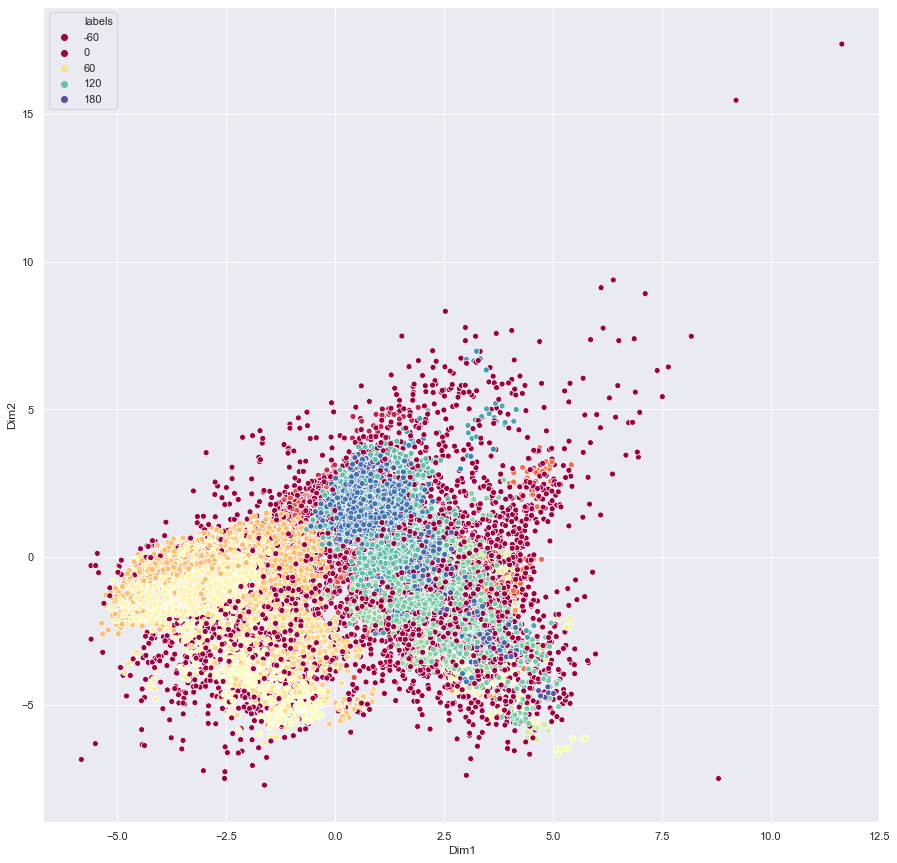

In [81]:

sns.set(rc = {'figure.figsize':(15,15)})
sns.scatterplot(data = df_cct_pca_df, x = "Dim1", y = "Dim2", hue = df_cct_pca_df["labels"], palette="Spectral")




In [86]:
# 2. UMAP : 


reducer = umap.UMAP()
reduced_X = reducer.fit_transform(df_cct.values)

In [87]:
reduced_df = pd.DataFrame(reduced_X, columns = ["A1", "A2"])
reduced_df["Label"] = clustering.labels_

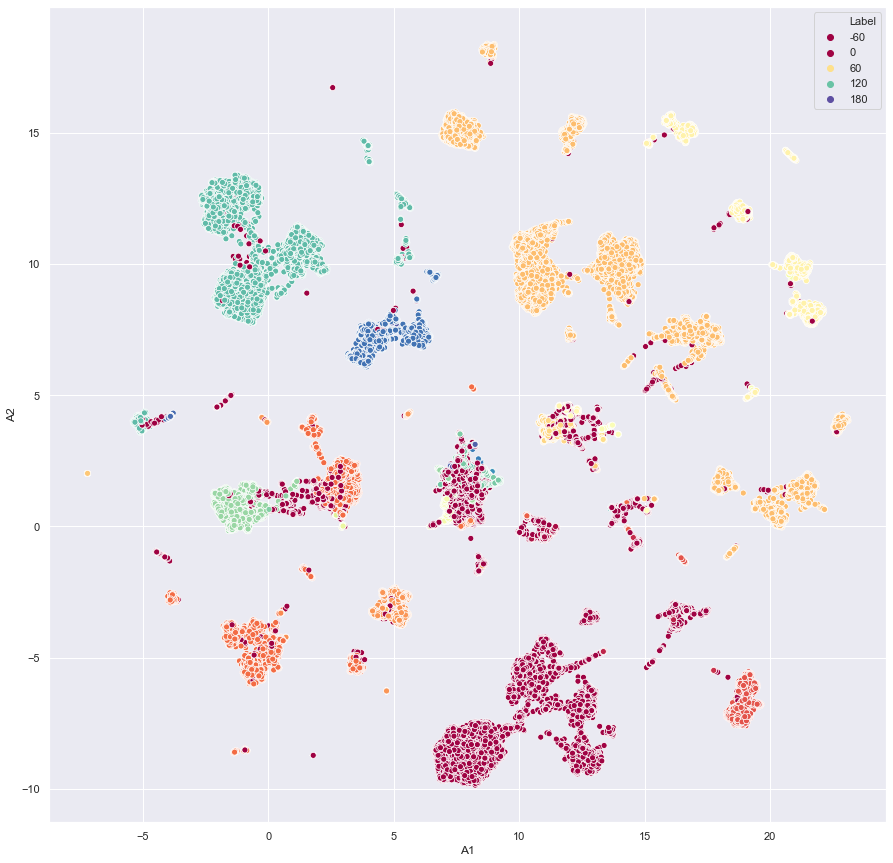

In [89]:
sns.set(rc = {'figure.figsize':(15,15)})
sns.scatterplot(data = reduced_df, x = "A1", y = "A2", hue = "Label", palette="Spectral")



In [93]:
# Interprétation : 
# Comprendre les différentes classes : 

# Exemple classe 120 :

df_cct["labels"] = clustering.labels_



In [119]:
df_cct120 = df_cct[df_cct['labels'] == 120]

In [120]:
df_cct120.describe()


,User,Card,Amount,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,delta_t_s,...,day_amt,day_nbt,day_med_nbt,wk_i_nbt,wk_med_nbt,wk_i_amt,wk_med_amt,wk_i_med_amt,nbt_wk_i/amt_wk_i,labels
count,6.000000e+00,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,...,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.0
mean,7.242241e-01,0.727420,1.567366,-0.912333,3.739928,1.381659,-1.242687,-0.754253,-0.117263,0.008566,...,0.931140,-0.794989,0.337882,-0.642158,-0.793079,1.082064,0.246195,1.543394,-0.754287,120.0
std,1.216188e-16,0.390438,0.608467,0.096841,0.312756,0.724259,1.130055,0.488945,0.000000,0.005748,...,0.346181,0.302082,0.000000,0.071350,0.000000,0.564681,0.063926,0.418801,0.036990,0.0
min,7.242241e-01,0.475394,0.395791,-1.110008,3.339296,0.279734,-2.171931,-0.953864,-0.117263,0.001519,...,0.423104,-1.041638,0.337882,-0.744201,-0.793079,0.416444,0.173328,1.057911,-0.787694,120.0
25%,7.242241e-01,0.475394,1.600627,-0.872798,3.475511,0.940889,-2.130258,-0.953864,-0.117263,0.005265,...,0.855395,-1.041638,0.337882,-0.676172,-0.793079,0.699544,0.213392,1.150849,-0.783834,120.0
50%,7.242241e-01,0.475394,1.712324,-0.872798,3.897892,1.602044,-1.460902,-0.953864,-0.117263,0.007192,...,0.865780,-0.856651,0.337882,-0.642158,-0.793079,1.043522,0.220919,1.662927,-0.766893,120.0
75%,7.242241e-01,1.042453,1.824020,-0.872798,3.963137,1.932621,-0.913770,-0.953864,-0.117263,0.012303,...,1.043669,-0.671664,0.337882,-0.608143,-0.793079,1.387500,0.299401,1.896190,-0.721590,120.0
max,7.242241e-01,1.231473,2.159111,-0.872798,3.984886,2.042814,0.722381,0.243802,-0.117263,0.016866,...,1.477276,-0.301691,0.337882,-0.540114,-0.793079,1.901850,0.325562,1.922495,-0.708276,120.0


In [124]:
print(len(df_cct120[df_cct120["Is Fraud?"] == -0.01617052139234396])) #Pas de Fraud
print(len(df_cct120[df_cct120["Is Fraud?"] != -0.01617052139234396])) #Fraud 

6
0


In [125]:
L = []
for i in range(len(df_cct['labels'].unique())):
    df_cctxxx = df_cct[df_cct['labels'] == i]
    if len(df_cctxxx[df_cctxxx["Is Fraud?"] == -0.01617052139234396]) <= len(df_cctxxx[df_cctxxx["Is Fraud?"] != -0.01617052139234396]):
        L.append(i)

L
    

[16, 152]

In [126]:
df_cct16 = df_cct[df_cct['labels'] == 16]
df_cct152 = df_cct[df_cct['labels'] == 152]

In [128]:
df_cct16.describe()

,User,Card,Amount,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,delta_t_s,...,day_amt,day_nbt,day_med_nbt,wk_i_nbt,wk_med_nbt,wk_i_amt,wk_med_amt,wk_i_med_amt,nbt_wk_i/amt_wk_i,labels
count,6.000000,6.000000e+00,6.000000,6.000000,6.000000,6.000000e+00,6.000000,6.000000,6.000000,6.000000,...,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.0
mean,-1.363499,1.231473e+00,-0.177064,0.235356,-0.232051,-4.916128e-01,0.538596,-0.373510,-0.117263,0.002628,...,1.725278,1.548176,0.337882,0.242222,-0.250347,1.529451,0.873159,0.801631,-0.446343,16.0
std,0.000000,2.432377e-16,0.287878,0.339293,0.231102,6.080942e-17,0.007945,0.007132,0.000000,0.001377,...,0.586662,0.906246,0.000000,0.271265,0.035930,0.492852,0.010581,0.364622,0.027683,0.0
min,-1.363499,1.231473e+00,-0.493911,-0.159569,-0.703651,-4.916128e-01,0.522506,-0.380008,-0.117263,0.001587,...,0.690361,0.438256,0.337882,-0.199968,-0.265015,0.524568,0.852255,0.286556,-0.494993,16.0
25%,-1.363499,1.231473e+00,-0.418255,-0.013567,-0.143912,-4.916128e-01,0.540690,-0.380008,-0.117263,0.001648,...,1.535328,1.178203,0.337882,0.106163,-0.265015,1.698095,0.873682,0.542739,-0.443655,16.0
50%,-1.363499,1.231473e+00,-0.181830,0.221784,-0.140478,-4.916128e-01,0.541276,-0.373916,-0.117263,0.001925,...,1.907223,1.178203,0.337882,0.412295,-0.265015,1.742185,0.878671,1.036248,-0.443655,16.0
75%,-1.363499,1.231473e+00,0.027732,0.443193,-0.133610,-4.916128e-01,0.542628,-0.366910,-0.117263,0.003480,...,2.140118,2.288123,0.337882,0.412295,-0.265015,1.742185,0.878671,1.036248,-0.443655,16.0
max,-1.363499,1.231473e+00,0.194663,0.703160,-0.131320,-4.916128e-01,0.542944,-0.366606,-0.117263,0.004778,...,2.217749,2.658097,0.337882,0.412295,-0.177005,1.742185,0.878671,1.036248,-0.408448,16.0


In [127]:
df_cct152.describe()

,User,Card,Amount,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,delta_t_s,...,day_amt,day_nbt,day_med_nbt,wk_i_nbt,wk_med_nbt,wk_i_amt,wk_med_amt,wk_i_med_amt,nbt_wk_i/amt_wk_i,labels
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
